In [1]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

In [3]:
d2l.try_gpu()

device(type='cuda', index=0)

In [4]:
train_data = pd.read_csv(os.path.join('.', 'data', 'house-prices-advanced-regression-techniques', 'train.csv'))
test_data = pd.read_csv(os.path.join('.', 'data', 'house-prices-advanced-regression-techniques', 'test.csv'))

train_data.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [5]:
# 'id'不携带任何用于预测的信息, 从特征中去掉
# train_data中最后一列价格也去掉
# 数据合并到一起做预处理
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

# 用均值和标准差将所有数值标准化
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(lambda x: (x - x.mean()) / (x.std()))

# 在标准化数据之后，所有均值消失，可以将缺失值设置为0
all_features[numeric_features] = all_features[numeric_features].fillna(0)

# "Dummy_na=True"将"na"视为有效的特征值，并为其创建指示符特征
all_features = pd.get_dummies(all_features, dummy_na=True, dtype=float)
all_features.shape

(2919, 330)

In [6]:
n_train = train_data.shape[0]
# 训练数据
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32).cuda(0)
# 测试数据
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32).cuda(0)
# 标签
train_labels = torch.tensor(train_data.SalePrice.values.reshape(-1, 1), dtype=torch.float32).cuda(0)

In [7]:
loss = nn.MSELoss()
in_features = train_features.shape[1]

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

def get_net():
    net = nn.Sequential(
        nn.Linear(in_features, 256),
        nn.ReLU(),
        nn.Linear(256, 1))
    net.apply(init_weights)
    net = net.to(device=d2l.try_gpu())
    return net

In [8]:
def log_rmse(net, features, labels):
    # 为了在取对数时进一步稳定该值，将小于1的值设置为1
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds), torch.log(labels)))
    return rmse.item()

In [9]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    # 这里使用的是Adam优化算法
    optimizer = torch.optim.Adam(net.parameters(),
                                 lr = learning_rate,
                                 weight_decay = weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

In [10]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'折{i + 1}，训练log rmse{float(train_ls[-1]):f}, '
              f'验证log rmse{float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

折1，训练log rmse0.122017, 验证log rmse0.130405
折2，训练log rmse0.121413, 验证log rmse0.141388
折3，训练log rmse0.120655, 验证log rmse0.135778
折4，训练log rmse0.125245, 验证log rmse0.118219
折5，训练log rmse0.108701, 验证log rmse0.156474
5-折验证: 平均训练log rmse: 0.119606, 平均验证log rmse: 0.136453


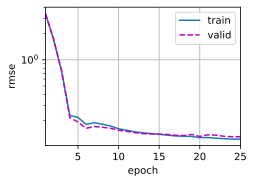

In [12]:
k, num_epochs, lr, weight_decay, batch_size = 5, 25, 0.05, 5, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

训练log rmse：0.114207


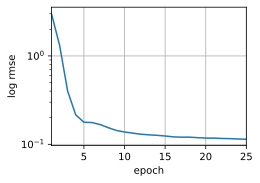

In [15]:
def train_and_pred(train_features, test_features, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'训练log rmse：{float(train_ls[-1]):f}')
    # 将网络应用于测试集。
    preds = net(test_features).cpu().detach().numpy()
    # 将其重新格式化以导出到Kaggle
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv(os.path.join('.', 'submission', 'house-prices-advanced-regression-techniques.csv'), index=False)

train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size)